<a href="https://colab.research.google.com/github/aryanasadianuoit/Adaptive-Graph-Based-Cohort-Creation-For-Deep-MutualLearning/blob/master/adaptive_graph_for_deep_mutual_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


169009152/169001437 [==============================] - 4s 0us/step
Epoch 1/30
1563/1563 [==============================] - 5s 3ms/step - loss: 3.9192 - accuracy: 0.0950
Epoch 2/30
1563/1563 [==============================] - 5s 3ms/step - loss: 3.2551 - accuracy: 0.2034
Epoch 3/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.9299 - accuracy: 0.2673
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7004 - accuracy: 0.3118
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.5194 - accuracy: 0.3484
Epoch 6/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3756 - accuracy: 0.3813
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.2330 - accuracy: 0.4113
Epoch 8/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.1207 - accuracy: 0.4329
Epoch 9/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.0025 - accuracy: 0.4599
Epoch 10/30
156

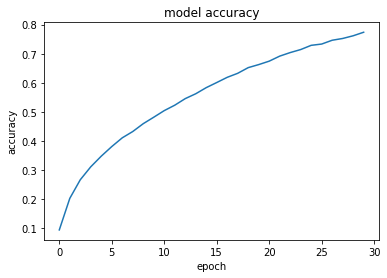

Model 1 : 
Initial training
Epoch 1/30
1563/1563 [==============================] - 5s 3ms/step - loss: 3.7194 - accuracy: 0.1355
Epoch 2/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.9558 - accuracy: 0.2671
Epoch 3/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.5968 - accuracy: 0.3361
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3661 - accuracy: 0.3858
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.1645 - accuracy: 0.4312
Epoch 6/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.9870 - accuracy: 0.4707
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8257 - accuracy: 0.5061
Epoch 8/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6635 - accuracy: 0.5420
Epoch 9/30
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5231 - accuracy: 0.5752
Epoch 10/30
1563/1563 [==============================]

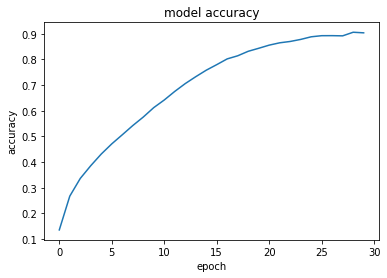

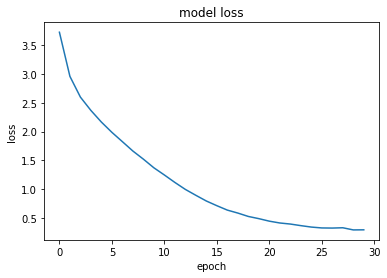

Model 2 : 
Initial training
Epoch 1/30
1563/1563 [==============================] - 5s 3ms/step - loss: 3.7539 - accuracy: 0.1281
Epoch 2/30
1563/1563 [==============================] - 5s 3ms/step - loss: 3.0325 - accuracy: 0.2525
Epoch 3/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.6997 - accuracy: 0.3160
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4719 - accuracy: 0.3645
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.2950 - accuracy: 0.4023
Epoch 6/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.1451 - accuracy: 0.4349
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 2.0074 - accuracy: 0.4637
Epoch 8/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8773 - accuracy: 0.4927
Epoch 9/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7590 - accuracy: 0.5189
Epoch 10/30
1563/1563 [==============================]

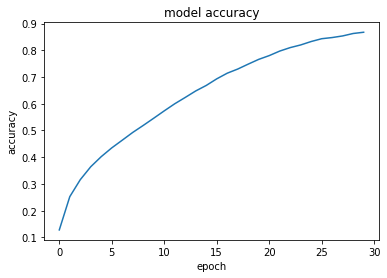

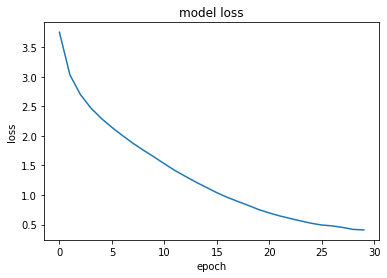

Size of the cohort :  3
Node index:  0
Cosine Loss :  tf.Tensor(-1.0000001, shape=(), dtype=float32)
Node index:  0
Cosine Loss :  tf.Tensor(-0.2538157, shape=(), dtype=float32)
YES
Distillation Training
Epoch 1/30
1563/1563 [==============================] - 7s 4ms/step - loss: 4.2602e-06 - accuracy: 0.4093
Epoch 2/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8329e-06 - accuracy: 0.5081
Epoch 3/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.7610e-06 - accuracy: 0.5605
Epoch 4/30
1563/1563 [==============================] - 6s 4ms/step - loss: 3.7187e-06 - accuracy: 0.5914
Epoch 5/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.6913e-06 - accuracy: 0.6055
Epoch 6/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.6701e-06 - accuracy: 0.6185
Epoch 7/30
1563/1563 [==============================] - 6s 4ms/step - loss: 3.6533e-06 - accuracy: 0.6306
Epoch 8/30
1563/1563 [==============================] 

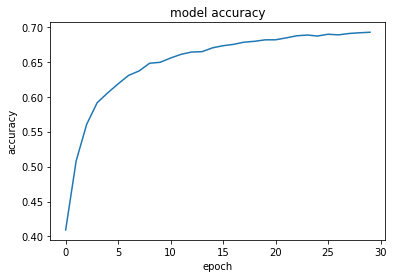

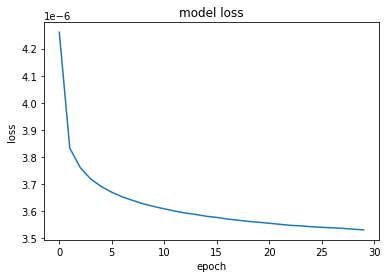

Node index:  0
Cosine Loss :  tf.Tensor(-0.2143296, shape=(), dtype=float32)
YES
Distillation Training
Epoch 1/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8691e-06 - accuracy: 0.6602
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 3.8479e-06 - accuracy: 0.6555
Epoch 3/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8399e-06 - accuracy: 0.6538
Epoch 4/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8341e-06 - accuracy: 0.6539
Epoch 5/30
1563/1563 [==============================] - 6s 4ms/step - loss: 3.8287e-06 - accuracy: 0.6529
Epoch 6/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8250e-06 - accuracy: 0.6563
Epoch 7/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8221e-06 - accuracy: 0.6535
Epoch 8/30
1563/1563 [==============================] - 7s 4ms/step - loss: 3.8182e-06 - accuracy: 0.6560
Epoch 9/30
 437/1563 [=======>...................

KeyboardInterrupt: ignored

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import theano
from keras import backend
from keras.losses import categorical_crossentropy as logloss
from keras.layers import Lambda, concatenate, Activation
import matplotlib.pyplot as plt
from google.colab import files

cifar100 = keras.datasets.cifar100
(training_images, training_labels), (testing_images, testing_labels) = cifar100.load_data()

temperature = 5
num_epochs =30

# Reshaping and normalizing the images

training_images = training_images.reshape(50000, 32, 32, 3)
training_images = training_images / 255.0
testing_images = testing_images.reshape(10000, 32, 32, 3)
testing_images = testing_images / 255.0

cohort_list = []


def train_basic():
    print("Initial training")
    basic_model = keras.models.Sequential([keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
                                                               activation=keras.activations.relu,
                                                               input_shape=(32, 32, 3)),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                                               activation=keras.activations.relu),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Flatten(),
                                           keras.layers.Dense(units=256, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.softmax)])
    #basic_model.summary()
    basic_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.sparse_categorical_crossentropy,
                        metrics=["accuracy"])
    history = basic_model.fit(x=training_images, y=training_labels, epochs= num_epochs, verbose=1)
    print(history.history.keys())
    #Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    #plt.savefig('basicacc.png')
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()  
    #plt.savefig('basicloss.png')
    #files.download("basicloss.png")

    return basic_model


def get_logits(basic_model):
    intermediate_input = basic_model.input
    intermediate_output = basic_model.get_layer(index=-2).output
    intermediate_layer_model = keras.models.Model(inputs=intermediate_input, outputs=intermediate_output)
    intermediate_output = intermediate_layer_model.predict(x=training_images)
    return np.array(intermediate_output)


def get_probabilities(basic_model):
    softmax_layer = keras.models.Model(inputs=basic_model.input,
                                       outputs=basic_model.get_layer(index=-1).output)
    probabilities = softmax_layer.predict(x=training_images)
    return np.array(probabilities)


def get_high_temp_probabilities(basic_model):
    intermediate_layer_model = keras.models.Model(inputs=basic_model.input,
                                                  outputs=basic_model.get_layer(index=-1).output)
    intermediate_output = intermediate_layer_model.predict(x=training_images)
    intermediate_output = np.array(intermediate_output) ** (1 / temperature)
    p_sum = intermediate_output.sum()
    sample_temp = intermediate_output / p_sum
    return sample_temp


def deep_mutual_training():
    for node in cohort_list:
        for other_nodes in range(0, len(cohort_list)):
            if node is cohort_list[other_nodes]:
                print("Same student")

            else:
               # print("Before reshape : ", np.shape(get_high_temp_probabilities(cohort_list[other_nodes])),"   ",np.shape(get_high_temp_probabilities(node)))
                truth = np.reshape(get_high_temp_probabilities(cohort_list[other_nodes]), newshape=-1)
                preds = np.reshape(get_high_temp_probabilities(node), newshape=-1)

                node.compile(optimizer=keras.optimizers.Adam(),
                             loss=lambda truth, preds: knowledge_distillation_loss(truth, preds),
                             metrics=['accuracy'])
                print("Distillation Training")
                history_1 = node.fit(x=training_images, y=get_high_temp_probabilities(cohort_list[other_nodes]),
                         epochs=30, verbose=1)
                plt.plot(history_1.history['accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                #plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                # summarize history for loss
                plt.plot(history_1.history['loss'])
                #plt.plot(history.history['loss'])
                plt.title('model loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                #plt.legend(['train', 'test'], loc='upper left')
                plt.show() 


def deep_mutual_training2():
    print("Size of the cohort : ",len(cohort_list))
    for node in cohort_list:
        for other_nodes in range(0, len(cohort_list)):
          print("Node index: ",cohort_list.index(node))

          # print("Before reshape : ", np.shape(get_high_temp_probabilities(cohort_list[other_nodes])),"   ",np.shape(get_high_temp_probabilities(node)))
          truth = np.reshape(get_high_temp_probabilities(cohort_list[other_nodes]), newshape=-1)
          preds = np.reshape(get_high_temp_probabilities(node), newshape=-1)
          truth_logits = np.reshape(get_logits(cohort_list[other_nodes]), newshape=-1)
          preds_logits = np.reshape(get_logits(node), newshape=-1)
          cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1)
          cosine_loss = cosine_loss(y_true=truth_logits,y_pred=preds_logits)
          print("Cosine Loss : ",cosine_loss)
          if(cosine_loss > -0.5):
            print("YES")
            node.compile(optimizer=keras.optimizers.Adam(),
                         loss=lambda truth, preds: knowledge_distillation_loss(truth, preds),
                         metrics=['accuracy'])
            print("Distillation Training")
            history_1 = node.fit(x=training_images, y=get_high_temp_probabilities(cohort_list[other_nodes]),
                               epochs=num_epochs, verbose=1)
            plt.plot(history_1.history['accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.show()
          #plt.savefig('distilledacc.png')
          #files.download("distilledacc.png")
          #summarize history for loss
            plt.plot(history_1.history['loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show() 
          #plt.savefig('distilled.png')
          #files.download("distilled.png")
        
          


def knowledge_distillation_loss(y_true, y_pred):    
    
    # split in 
    #    onehot hard true targets
    #    logits from xception
    y_true, logits = y_true[:, :100], y_true[:, 100:]
    
    # convert logits to soft targets
    y_soft = backend.softmax(logits/temperature)
    
    # split in 
    #    usual output probabilities
    #    probabilities made softer with temperature
    y_pred, y_pred_soft = y_pred[:, :100], y_pred[:, 100:]    
    
    return 1/20*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)
    #return logloss(y_soft, y_pred_soft)





basic_model1 = keras.models.Sequential([keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                                               activation=keras.activations.relu,
                                                               input_shape=(32, 32, 3)),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                                               activation=keras.activations.relu),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Flatten(),
                                           keras.layers.Dense(units=256, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.softmax)])
    #basic_model.summary()
basic_model1.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=["accuracy"])
history = basic_model1.fit(x=training_images, y=training_labels, epochs= num_epochs, verbose=1)
#print(history.history.keys())
    #Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

cohort_list.append(basic_model1)



# basic_model2 = keras.models.Sequential([keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
#                                                                activation=keras.activations.relu,
#                                                                input_shape=(32, 32, 3)),
#                                            keras.layers.MaxPool2D(2, 2),
#                                            keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
#                                                                activation=keras.activations.relu),
#                                            keras.layers.MaxPool2D(2, 2),
#                                            keras.layers.Flatten(),
#                                            keras.layers.Dense(units=100, activation=keras.activations.softmax)])
#     #basic_model.summary()
# basic_model1.compile(optimizer=keras.optimizers.Adam(),
#                     loss=keras.losses.sparse_categorical_crossentropy,
#                     metrics=["accuracy"])
# basic_model1.fit(x=training_images, y=training_labels, epochs= num_epochs, verbose=1)

# cohort_list.append(basic_model2)





print("Model 1 : ")
cohort_list.append(train_basic())
print("Model 2 : ")
cohort_list.append(train_basic())
#print("Model 3 : ")
#cohort_list.append(train_basic())
#print("Model 4 : ")

#for node in cohort_list:
    #print("Node : ", node)
    #print(get_logits(node))
    #print("********************************")
    #print(get_probabilities(node))
    #print("********************************")
    #print(get_high_temp_probabilities(node))
    #print("###############################\n\n")

#deep_mutual_training()
deep_mutual_training2()

